# Experiments with Unsupervised Contrastive Learning

I want to be able to understand each component of each model. This will be achieved by carefully designing experiments. I will first use the synthetic data as a first pass and see how our unsupervised model performs on it. The control variables I will use are the following:
1. Same dataset size. I will divide windows from 100 spectrograms, stride = 10, window_size = 100 into training and testing datasets. 
2. Same neural network architecture. I will use the TweetyNet model as our convolutional frontend
3. Same model hyperparameters 

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.signal as signal
# import sounddevice as sd  
from scipy.io.wavfile import write
import pandas as pd
import seaborn as sns 
import umap
import os 
from bokeh.plotting import figure, show, output_file, save
from bokeh.models import HoverTool, ColumnDataSource
import seaborn as sns
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.cuda import amp
from torch.utils.data import DataLoader, TensorDataset
from pytorch_metric_learning import losses


sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [3]:
# Parameters we set
num_spec = 50
window_size = 500
stride = 10


phrase_repeats = 5
num_songs = 50
radius_value = 0.01
num_syllables = 10

folderpath = '/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/'
songpath = f'{folderpath}num_songs_{num_songs}_num_syllables_{num_syllables}_phrase_repeats_{phrase_repeats}_radius_{radius_value}/'
spec_path = f'{songpath}Num_Spectrograms_{num_spec}_Window_Size_{window_size}_Stride_{stride}/'


### Loading results from a previous analysis

In [4]:
# Let's save all the numpy arrays
stacked_windows = np.load(spec_path+'stacked_windows.npy')
stacked_labels_for_window = np.load(spec_path+'stacked_labels_for_window.npy')
masked_frequencies = np.load(spec_path+'masked_frequencies_lowthresh_600_highthresh_4000.npy')
stacked_window_times = np.load(spec_path+'stacked_window_times.npy')
mean_colors_per_minispec = np.load(spec_path+'mean_colors_per_minispec.npy')
embedding_50k = np.load(songpath+'UMAP_Embedding_of_spec.npy')

In [5]:
stacked_windows_for_analysis = stacked_windows[:50000,:]

from statistics import mode
actual_labels = np.apply_along_axis(lambda x: mode(x), axis=1, arr=stacked_labels_for_window)

# Shuffle the indices of stacked_windows
shuffled_indices = np.load(f'{spec_path}/shuffled_indices.npy')

# Shuffle array1 using the shuffled indices
stacked_windows_for_analysis = stacked_windows_for_analysis[shuffled_indices,:]

# Shuffle array2 using the same shuffled indices
stacked_labels_for_analysis= stacked_labels_for_window[shuffled_indices,:]

mean_colors_per_minispec_for_analysis = mean_colors_per_minispec[shuffled_indices, :]

actual_labels_for_analysis = actual_labels[shuffled_indices]

#### Let's make sure no issues were made in shuffling

In [6]:
embedding_check = embedding_50k.copy()

In [7]:
mean_colors_per_minispec.shape

(125172, 3)

In [8]:
# Specify an HTML file to save the Bokeh image to.
output_file(filename=f'{songpath}Num_Spectrograms_{num_spec}_Window_Size_{window_size}_Stride_{stride}/Plots/umap.html')

# Convert the UMAP embedding to a Pandas Dataframe
spec_df = pd.DataFrame(embedding_check, columns=('x', 'y'))


# Create a ColumnDataSource from the data. This contains the UMAP embedding components and the mean colors per mini-spectrogram
source = ColumnDataSource(data=dict(x = embedding_check[:,0], y = embedding_check[:,1], colors=mean_colors_per_minispec_for_analysis))


# Create a figure and add a scatter plot
p = figure(width=800, height=600, tools=('pan, box_zoom, hover, reset'))
p.scatter(x='x', y='y', size = 7, color = 'colors', source=source)

hover = p.select(dict(type=HoverTool))
hover.tooltips = """
    <div>
        <h3>@x, @y</h3>
        <div>
            <img
                src="@image" height="100" alt="@image" width="100"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
    </div>
"""

p.add_tools(HoverTool(tooltips="""
"""))


# Set the image path for each data point
# source.data['image'] = []
# for i in np.arange(spec_df.shape[0]):
#     source.data['image'].append(f'{folder_name}/Plots/Window_Plots/Window_{i}.png')

show(p)


Let's remove transition slices from the 50k dataset. 

In [9]:
transition_rows = np.where(np.apply_along_axis(lambda x: len(np.unique(x)) >= 3, 1, stacked_labels_for_analysis))[0]


In [10]:
transition_rows

array([    4,    14,    18, ..., 49992, 49994, 49996])

In [11]:
stacked_windows_for_analysis_nontransitions = np.delete(stacked_windows_for_analysis, transition_rows, axis = 0)
mean_colors_per_minispec_for_analysis_nontransitions = np.delete(mean_colors_per_minispec_for_analysis, transition_rows, axis = 0)
stacked_labels_for_analysis_nontransitions = np.delete(stacked_labels_for_analysis, transition_rows, axis = 0)
actual_labels_for_analysis_nontransitions = np.apply_along_axis(lambda x: mode(x), axis=1, arr=stacked_labels_for_analysis_nontransitions)

Let's Z-score

In [12]:
mean = np.mean(stacked_windows_for_analysis_nontransitions, axis=1, keepdims=True)
std = np.std(stacked_windows_for_analysis_nontransitions, axis=1, keepdims=True)
    
# z-score each row
# zscored = (stacked_windows_for_analysis - mean) / std
zscored = (stacked_windows_for_analysis_nontransitions - mean) / (std + 1e-7)

dat = zscored.copy()

Let's look at the UMAP representation of non-transitions

In [13]:
embedding_nontransitions = np.load(spec_path+'UMAP_Embedding_of_spec_non_transitions_subset_data.npy')

In [14]:
# Specify an HTML file to save the Bokeh image to.
output_file(filename=f'{songpath}Num_Spectrograms_{num_spec}_Window_Size_{window_size}_Stride_{stride}/Plots/umap_non_transitions.html')

# Convert the UMAP embedding to a Pandas Dataframe
spec_df = pd.DataFrame(embedding_nontransitions, columns=('x', 'y'))


# Create a ColumnDataSource from the data. This contains the UMAP embedding components and the mean colors per mini-spectrogram
source = ColumnDataSource(data=dict(x = embedding_nontransitions[:,0], y = embedding_nontransitions[:,1], colors=mean_colors_per_minispec_for_analysis_nontransitions))


# Create a figure and add a scatter plot
p = figure(width=800, height=600, tools=('pan, box_zoom, hover, reset'))
p.scatter(x='x', y='y', size = 7, color = 'colors', source=source)

hover = p.select(dict(type=HoverTool))
hover.tooltips = """
    <div>
        <h3>@x, @y</h3>
        <div>
            <img
                src="@image" height="100" alt="@image" width="100"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
    </div>
"""

p.add_tools(HoverTool(tooltips="""
"""))


# Set the image path for each data point
# source.data['image'] = []
# for i in np.arange(spec_df.shape[0]):
#     source.data['image'].append(f'{folder_name}/Plots/Window_Plots/Window_{i}.png')

show(p)
# save(p)

#### Creating training/testing dataset

In [15]:
# I want to make training indices to be the first 80% of the shuffled data
split_point = int(0.8*dat.shape[0])

stacked_windows_train = torch.tensor(dat[:split_point, :])
stacked_windows_train = stacked_windows_train.reshape(stacked_windows_train.shape[0], 1, 500, 40)

stacked_labels_train = stacked_labels_for_analysis_nontransitions[:split_point,:]
mean_colors_per_minispec_train = mean_colors_per_minispec_for_analysis_nontransitions[:split_point,:]
actual_labels_train = torch.tensor(actual_labels_for_analysis_nontransitions[:split_point])

# The testing data will be the left-out 20%

stacked_windows_test = torch.tensor(dat[split_point:, :])
stacked_windows_test = stacked_windows_test.reshape(stacked_windows_test.shape[0], 1, 500, 40)

stacked_labels_test = stacked_labels_for_analysis_nontransitions[split_point:,:]
mean_colors_per_minispec_test = mean_colors_per_minispec_for_analysis_nontransitions[split_point:,:]
actual_labels_test = torch.tensor(actual_labels_for_analysis_nontransitions[split_point:])

In [16]:
train_dataset = TensorDataset(stacked_windows_train, actual_labels_train)
test_dataset = TensorDataset(stacked_windows_test, actual_labels_test)

# Define batch size
# batch_size = CFG.batch_size
batch_size = 128

# Create a DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
# Create the folder if it doesn't already exist
if not os.path.exists(f'{spec_path}Plots/Window_Plots'):
    os.makedirs(f'{spec_path}Plots/Window_Plots')
    print(f'{spec_path}Plots/Window_Plots created successfully.')
else:
    print(f'{spec_path}Plots/Window_Plots already exists.')

/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/num_songs_50_num_syllables_10_phrase_repeats_5_radius_0.01/Num_Spectrograms_50_Window_Size_500_Stride_10/Plots/Window_Plots already exists.


In [18]:
dat.shape

(40333, 20000)

In [ ]:
# The below function will save an image for each mini-spectrogram. This will be used for understanding the UMAP plot.
def embeddable_image(data, window_times, iteration_number):
    
    data.shape = (window_size, int(data.shape[0]/window_size))
    data = data.T 
    window_times = window_times.reshape(1, window_times.shape[0])
    plt.pcolormesh(window_times, masked_frequencies, data, cmap='jet')
    # let's save the plt colormesh as an image.
    plt.savefig(f'{songpath}Num_Spectrograms_{num_spec}_Window_Size_{window_size}_Stride_{stride}/Plots/Window_Plots/Window_{iteration_number}.png')
    plt.close()
    
for i in np.arange(stacked_windows_for_analysis.shape[0]):
    if i%10 == 0:
        print(f'Iteration {i} of 50000')
    data = stacked_windows_for_analysis[i,:]
    window_times = stacked_window_times[i,:]
    embeddable_image(data, window_times, i)

TweetyNet Specification 

In [19]:
class TweetyNetCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=32, kernel_size=(5, 5), stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=(8, 1), stride=(8, 1))
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=(5, 5), stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=(8, 1), stride=(8, 1))
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(16128, 4000)
        self.fc2 = nn.Linear(4000, 1000)
        # self.fc3 = nn.Linear(100, 1)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        
        # Encoder f
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = self.relu(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

In [20]:
patience = 20
learning_rate = 0.001
projection_units = 1000
num_epochs = 100

if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

# Check if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    # If so, wrap the model using nn.DataParallel
    cnn_model = nn.DataParallel(TweetyNetCNN()).double()
else:
    cnn_model = TweetyNetCNN().double()

      
# cnn_model = TweetyNetCNN()
# cnn_model.double().to(device)
cnn_model.to(device)  # Send model to GPU

Using 2 GPUs!


DataParallel(
  (module): TweetyNetCNN(
    (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=(8, 1), stride=(8, 1), padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=(8, 1), stride=(8, 1), padding=0, dilation=1, ceil_mode=False)
    (relu): ReLU()
    (fc1): Linear(in_features=16128, out_features=4000, bias=True)
    (fc2): Linear(in_features=4000, out_features=1000, bias=True)
  )
)

#### Extract Untrained model embedding

In [21]:
files = os.listdir(f'{songpath}Num_Spectrograms_{num_spec}_Window_Size_{window_size}_Stride_{stride}/')
all_batches = [element for element in files if 'untrained_backbone_rep_of_batch_index_' in element] # Get the file paths of each numpy file from Yarden's data
all_batches.sort()

In [22]:
embedding_arr = np.empty((0, 4000))
for i in all_batches:
    arr = np.load(f'{songpath}Num_Spectrograms_{num_spec}_Window_Size_{window_size}_Stride_{stride}/{i}')
    embedding_arr = np.concatenate((embedding_arr, arr))

In [23]:
files = os.listdir(f'{songpath}Num_Spectrograms_{num_spec}_Window_Size_{window_size}_Stride_{stride}/')
all_batches = [element for element in files if 'untrained_proj_rep_of_batch_index_' in element] # Get the file paths of each numpy file from Yarden's data
all_batches.sort()

In [24]:
proj_arr = np.empty((0, 1000))
for i in all_batches:
    arr = np.load(f'{songpath}Num_Spectrograms_{num_spec}_Window_Size_{window_size}_Stride_{stride}/{i}')
    proj_arr = np.concatenate((proj_arr, arr))

In [25]:
untrained_backbone_umap_rep = np.load(f'{songpath}Num_Spectrograms_{num_spec}_Window_Size_{window_size}_Stride_{stride}/backbone_umap_rep_of_untrained_model_embedding.npy')

In [26]:
untrained_proj_umap_rep = np.load(f'{songpath}Num_Spectrograms_{num_spec}_Window_Size_{window_size}_Stride_{stride}/proj_umap_rep_of_untrained_model_embedding.npy')

UMAP representation of untrained model backbone

In [27]:
# Specify an HTML file to save the Bokeh image to.
output_file(filename=f'{songpath}Num_Spectrograms_{num_spec}_Window_Size_{window_size}_Stride_{stride}/Plots/umap_of_untrained_model_backbone.html')

# Convert the UMAP embedding to a Pandas Dataframe
spec_df = pd.DataFrame(untrained_backbone_umap_rep, columns=('x', 'y'))


# Create a ColumnDataSource from the data. This contains the UMAP embedding components and the mean colors per mini-spectrogram
source = ColumnDataSource(data=dict(x = untrained_backbone_umap_rep[:,0], y = untrained_backbone_umap_rep[:,1], colors=mean_colors_per_minispec_train))


# Create a figure and add a scatter plot
p = figure(width=800, height=600, tools=('pan, box_zoom, hover, reset'))
p.scatter(x='x', y='y', size = 7, color = 'colors', source=source)

hover = p.select(dict(type=HoverTool))
hover.tooltips = """
    <div>
        <h3>@x, @y</h3>
        <div>
            <img
                src="@image" height="100" alt="@image" width="100"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
    </div>
"""

p.add_tools(HoverTool(tooltips="""
"""))


# Now let's overlay the spectrogram slice images. We want to exclude the transition state slices and also consider the shuffling

total_indices = np.arange(0, stacked_windows.shape[0])
# total_indices = np.delete(total_indices, transition_rows[0])
total_indices = total_indices[shuffled_indices]
train_indices = total_indices[:split_point]

# Set the image path for each data point
# source.data['image'] = []
# for i in np.arange(train_indices.shape[0]):
#     source.data['image'].append(f'{folder_name_for_plotting}/Plots/Window_Plots/Window_{train_indices[i]}.png')

show(p)
# save(p)

UMAP representation of untrained model backbone

In [28]:
# Specify an HTML file to save the Bokeh image to.
output_file(filename=f'{songpath}Num_Spectrograms_{num_spec}_Window_Size_{window_size}_Stride_{stride}/Plots/umap_of_untrained_model_projection.html')

# Convert the UMAP embedding to a Pandas Dataframe
spec_df = pd.DataFrame(untrained_proj_umap_rep, columns=('x', 'y'))


# Create a ColumnDataSource from the data. This contains the UMAP embedding components and the mean colors per mini-spectrogram
source = ColumnDataSource(data=dict(x = untrained_proj_umap_rep[:,0], y = untrained_proj_umap_rep[:,1], colors=mean_colors_per_minispec_train))


# Create a figure and add a scatter plot
p = figure(width=800, height=600, tools=('pan, box_zoom, hover, reset'))
p.scatter(x='x', y='y', size = 7, color = 'colors', source=source)

hover = p.select(dict(type=HoverTool))
hover.tooltips = """
    <div>
        <h3>@x, @y</h3>
        <div>
            <img
                src="@image" height="100" alt="@image" width="100"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
    </div>
"""

p.add_tools(HoverTool(tooltips="""
"""))


# Now let's overlay the spectrogram slice images. We want to exclude the transition state slices and also consider the shuffling

total_indices = np.arange(0, stacked_windows.shape[0])
# total_indices = np.delete(total_indices, transition_rows[0])
total_indices = total_indices[shuffled_indices]
train_indices = total_indices[:split_point]

# # Set the image path for each data point
# source.data['image'] = []
# for i in np.arange(train_indices.shape[0]):
#     source.data['image'].append(f'{folder_name_for_plotting}/Plots/Window_Plots/Window_{train_indices[i]}.png')

show(p)
# save(p)

The backbone representation and the projection representation look the same using the untrained model. NOw let's train the model and compare. 

### Setting up Contrastive Learning

#### Augmentation Class

We will use a white noise augmentation to start off with

In [29]:
class White_Noise:
    def __init__(self, noise_level):
        
        self.noise_level = noise_level
        
    def __call__(self, x):
        
        noise = torch.randn_like(x) * self.noise_level
        x = x + noise
        return x

# Transforms
noise_level = 1
wn = White_Noise(noise_level)

Let's see what this augmentation type looks like

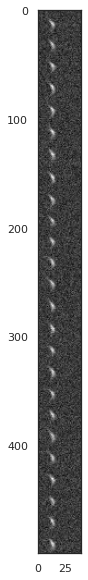

In [30]:
a = stacked_windows_train.clone()
aa = a[11,:]
aa = aa.reshape(500, 40)
b = wn(aa)
plt.figure()
plt.imshow(b, cmap = 'gray')


Extract model representation for each training spectrogram slice

In [31]:
files = os.listdir(f'{songpath}Num_Spectrograms_{num_spec}_Window_Size_{window_size}_Stride_{stride}/')
all_batches = [element for element in files if '_tryagain_trained_proj_rep_of_batch_index_' in element] # Get the file paths of each numpy file from Yarden's data
all_batches.sort()

In [32]:
proj_arr = np.empty((0, 1000))
for i in all_batches:
    arr = np.load(f'{songpath}Num_Spectrograms_{num_spec}_Window_Size_{window_size}_Stride_{stride}/{i}')
    proj_arr = np.concatenate((proj_arr, arr))

In [ ]:
trained_proj_umap_rep = np.load(f'{spec_path}trained_proj_umap_rep.npy')

In [33]:
reducer = umap.UMAP()
trained_proj_umap_rep = reducer.fit_transform(proj_arr)
np.save(f'{spec_path}trained_proj_umap_rep.npy', trained_proj_umap_rep)

/usr/lib/python3/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [34]:
# Specify an HTML file to save the Bokeh image to.
output_file(filename=f'{songpath}Num_Spectrograms_{num_spec}_Window_Size_{window_size}_Stride_{stride}/Plots/umap_of_trained_model_projection.html')

# Convert the UMAP embedding to a Pandas Dataframe
spec_df = pd.DataFrame(trained_proj_umap_rep, columns=('x', 'y'))


# Create a ColumnDataSource from the data. This contains the UMAP embedding components and the mean colors per mini-spectrogram
source = ColumnDataSource(data=dict(x = trained_proj_umap_rep[:,0], y = trained_proj_umap_rep[:,1], colors=mean_colors_per_minispec_train))


# Create a figure and add a scatter plot
p = figure(width=800, height=600, tools=('pan, box_zoom, hover, reset'))
p.scatter(x='x', y='y', size = 7, color = 'colors', source=source)

hover = p.select(dict(type=HoverTool))
hover.tooltips = """
    <div>
        <h3>@x, @y</h3>
        <div>
            <img
                src="@image" height="100" alt="@image" width="100"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
    </div>
"""

p.add_tools(HoverTool(tooltips="""
"""))


# Now let's overlay the spectrogram slice images. We want to exclude the transition state slices and also consider the shuffling

total_indices = np.arange(0, stacked_windows.shape[0])
# total_indices = np.delete(total_indices, transition_rows[0])
total_indices = total_indices[shuffled_indices]
train_indices = total_indices[:split_point]

# # Set the image path for each data point
# source.data['image'] = []
# for i in np.arange(train_indices.shape[0]):
#     source.data['image'].append(f'{folder_name_for_plotting}/Plots/Window_Plots/Window_{train_indices[i]}.png')

show(p)
# save(p)

#### Downstream classifier

In [35]:
lab_vals_arr = actual_labels_train.clone().cpu().detach().numpy()
lab_vals_arr.shape

(32266,)

In [36]:
from sklearn.svm import SVC
# Create a SVM classifier with a radial basis function (RBF) kernel
clf = SVC(kernel='linear', C=1, probability= True, decision_function_shape='ovr')

# Train the classifier
clf.fit(proj_arr, lab_vals_arr)

# Predict on test data
y_pred = clf.predict(proj_arr)

# Calculate the accuracy
accuracy = (y_pred == lab_vals_arr).mean()
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 1.0000


In [37]:
np.unique(lab_vals_arr).shape[0]

10

In [38]:
from scipy.stats import ks_2samp

n_classes = np.unique(lab_vals_arr).shape[0]
ks_statistics = []

for i in range(n_classes):
    # Get the predicted probabilities for the class being positive
    positive_probs = clf.predict_proba(proj_arr)[:, i]
    
    # Combine predicted probabilities of all other classes as negative
    negative_probs = clf.predict_proba(proj_arr)[:, :i].sum(axis=1) + clf.predict_proba(proj_arr)[:, i+1:].sum(axis=1)
    
    # Compute the KS statistic
    ks_stat, p_value = ks_2samp(positive_probs, negative_probs)
    ks_statistics.append(ks_stat)

    print(f"KS Statistic for Class {i}: {ks_stat:.3f}")

KS Statistic for Class 0: 0.839
KS Statistic for Class 1: 0.843
KS Statistic for Class 2: 0.888
KS Statistic for Class 3: 0.831
KS Statistic for Class 4: 0.858
KS Statistic for Class 5: 0.805
KS Statistic for Class 6: 0.841
KS Statistic for Class 7: 0.814
KS Statistic for Class 8: 0.814
KS Statistic for Class 9: 0.838
